In [64]:
from langchain.document_loaders import JSONLoader
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain.llms import OpenAI
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from pathlib import Path
from pprint import pprint

import json

load_dotenv()

True

## Load Records

In [2]:
coords_path = "/Users/davidrose/git/chatlas/data/location_history/Records.json"

with open(coords_path) as f:
    data = json.load(f)

In [22]:
df_loc = pd.json_normalize(data["locations"])
df_loc["timestamp"] = pd.to_datetime(df_loc["timestamp"])
df = df_loc.sample(10_000)

# Function to extract the top activity
def get_top_activity(activities):
    # If list
    if isinstance(activities, list):
        if not activities:  # Check for empty list
            return None
    
        # Good case
        top_activities = []
        for i in activities:
            top = max(i["activity"], key=lambda x: x["confidence"])
            top_activities.append(top)
        single_top_activity = max(top_activities, key=lambda x: x["confidence"])
        return single_top_activity
    
    # If nan float
    elif pd.isna(activities):
        return None

# Apply the function to each row and store in a new column
df["top_activity"] = df["activity"].apply(get_top_activity)
df["confidence"] = df["top_activity"].apply(lambda x: x["confidence"] if x else None)
df["top_activity"] = df["top_activity"].apply(lambda x: x["type"] if x else None)

# Drop the old activity column
df.drop(columns=["activity"], inplace=True)

# lowercase all columns
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [23]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)

In [24]:
agent.run("What are my top 3 activities?")



> Entering new AgentExecutor chain...
Thought: I need to find the top 3 activities in the dataframe
Action: python_repl_ast
Action Input: df['top_activity'].value_counts().head(3)
Observation: still      1965
tilting    1012
unknown     301
Name: top_activity, dtype: int64
Thought: I now know the top 3 activities
Final Answer: still, tilting, and unknown

> Finished chain.


'still, tilting, and unknown'

In [25]:
df.head(3).T

,2054221,2102316,1692430
latitudeE7,337800110,338538686,413823862
longitudeE7,-843902467,-843669955,21723678
accuracy,16,65,14
source,wifi,NaN,wifi
timestamp,2019-11-29 15:04:29.611000+00:00,2020-08-23 03:36:11.015000+00:00,2018-09-09 02:43:14.494000+00:00
deviceDesignation,NaN,NaN,primary
deviceTag,1794310557.0,-1949129349.0,-2093536168.0
platformType,NaN,NaN,NaN
serverTimestamp,NaN,NaN,NaN
deviceTimestamp,NaN,NaN,NaN


## Load Semantic

In [28]:
import os

data_folder = "/Users/davidrose/git/chatlas/data/location_history/semantic/2023"
data_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.json')]

data = []
for file in data_files:
    with open(file, 'r') as f:
        data.append(json.load(f))

dfs = pd.json_normalize(data)


In [48]:
activity_segments = []
place_visits = []
for i in data[0]["timelineObjects"]:
    if "activitySegment" in i.keys():
        activity_segments.append(i["activitySegment"])
    if "placeVisit" in i.keys():
        place_visits.append(i["placeVisit"])

df_activity_segments = pd.json_normalize(activity_segments)
df_place_visits = pd.json_normalize(place_visits)

In [52]:
df_activity_segments

,distance,activityType,confidence,activities,startLocation.latitudeE7,startLocation.longitudeE7,startLocation.sourceInfo.deviceTag,endLocation.latitudeE7,endLocation.longitudeE7,endLocation.sourceInfo.deviceTag,duration.startTimestamp,duration.endTimestamp,waypointPath.waypoints,waypointPath.source,waypointPath.roadSegment,waypointPath.distanceMeters,waypointPath.travelMode,waypointPath.confidence,simplifiedRawPath.points,transitPath.transitStops,transitPath.name,transitPath.hexRgbColor,transitPath.linePlaceId,transitPath.stopTimesInfo,transitPath.source,transitPath.confidence,transitPath.distanceMeters,simplifiedRawPath.source,simplifiedRawPath.distanceMeters,parkingEvent.location.latitudeE7,parkingEvent.location.longitudeE7,parkingEvent.location.accuracyMetres,parkingEvent.method,parkingEvent.locationSource,parkingEvent.timestamp
0,2448,WALKING,MEDIUM,"[{'activityType': 'WALKING', 'probability': 76...",500785667,144278054,629497835,500787018,144279339,629497835,2023-08-01T18:18:11.999Z,2023-08-01T18:49:25.912Z,"[{'latE7': 500785217, 'lngE7': 144280748}, {'l...",INFERRED,"[{'placeId': 'ChIJiwiJEI2UC0cRCqknsAHvO90', 'd...",2782.970653,WALK,0.998063,"[{'latE7': 500845642, 'lngE7': 144228735, 'acc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2840,WALKING,HIGH,"[{'activityType': 'WALKING', 'probability': 86...",500788023,144279417,629497835,500911554,144017579,629497835,2023-08-02T12:52:19Z,2023-08-02T13:33:01.780Z,"[{'latE7': 500787658, 'lngE7': 144281711}, {'l...",INFERRED,"[{'placeId': 'ChIJiwiJEI2UC0cRCqknsAHvO90', 'd...",1131.754810,WALK,0.990555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2515,WALKING,HIGH,"[{'activityType': 'WALKING', 'probability': 94...",500888963,144011845,629497835,500785174,144281846,629497835,2023-08-02T15:32:13.999Z,2023-08-02T15:59:14Z,"[{'latE7': 500890502, 'lngE7': 144012918}, {'l...",INFERRED,"[{'placeId': 'ChIJA_RFAh6VC0cRUxxPsX1U6fo', 'd...",2833.458534,WALK,0.994895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,443,WALKING,HIGH,"[{'activityType': 'WALKING', 'probability': 85...",500787902,144279045,629497835,500787946,144340982,629497835,2023-08-03T18:47:53.999Z,2023-08-03T18:53:41.999Z,"[{'latE7': 500787467, 'lngE7': 144281635}, {'l...",INFERRED,"[{'placeId': 'ChIJiwiJEI2UC0cRCqknsAHvO90', 'd...",536.110241,WALK,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1188,WALKING,MEDIUM,"[{'activityType': 'WALKING', 'probability': 76...",500790540,144349689,629497835,500786745,144277062,629497835,2023-08-03T19:36:53.073Z,2023-08-03T19:50:47Z,"[{'latE7': 500789413, 'lngE7': 144352827}, {'l...",INFERRED,"[{'placeId': 'ChIJw1ETIY6UC0cRH-ueSLs5n3U', 'd...",1314.792161,WALK,0.994212,"[{'latE7': 500824318, 'lngE7': 144264345, 'acc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,844,WALKING,HIGH,"[{'activityType': 'WALKING', 'probability': 83...",522347312,210161016,629497835,522332529,210195531,629497835,2023-08-31T10:58:46.950Z,2023-08-31T11:15:36.456Z,"[{'latE7': 522347526, 'lngE7': 210162124}, {'l...",INFERRED,"[{'placeId': 'ChIJo_YMr_XMHkcRkZTsEGoKu_I', 'd...",344.351754,WALK,0.999940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,254,WALKING,HIGH,"[{'activityType': 'WALKING', 'probability': 85...",522340486,210190459,629497835,522348398,210161379,629497835,2023-08-31T12:07:14.950Z,2023-08-31T12:11:27.179Z,"[{'latE7': 522340469, 'lngE7': 210190505}, {'l...",INFERRED,"[{'placeId': 'ChIJ-7FA1_XMHkcROQL1ReL4K98', 'd...",325.208554,WALK,0.998755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,8293,IN_PASSENGER_VEHICLE,MEDIUM,"[{'activityType': 'IN_PASSENGER_VEHICLE', 'pro...",522346972,210158342,629497835,521919594,209358667,629497835,2023-08-31T16:17:54.999Z,2023-08-31T16:46:19.329Z,"[{'

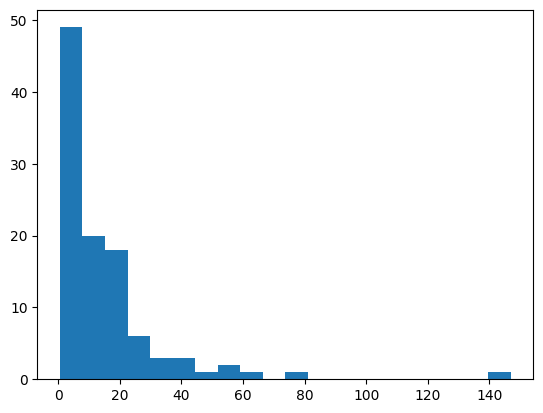

In [70]:
mins = []
maxs = []
durations = []
for ix, row in df_activity_segments.iterrows():
    min_time = row["duration.startTimestamp"]
    max_time = row["duration.endTimestamp"]
    
    def parse_datetime(dt_str):
        try:
            # Try the format with milliseconds
            return datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        except ValueError:
            # Fall back to the format without milliseconds
            return datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%SZ')

    # Convert to dt
    min_time = parse_datetime(min_time)
    max_time = parse_datetime(max_time)

    # Calculate duration
    duration = (max_time - min_time).seconds

    # Append to lists
    mins.append(min_time)
    maxs.append(max_time)
    durations.append(duration / 60)

# plot the durations as hist
plt.hist(durations, bins=20)
plt.show()

In [67]:
durations[0].seconds

1873

In [43]:
pd.json_normalize(data[0]["timelineObjects"][0]["activitySegment"])

,distance,activityType,confidence,activities,startLocation.latitudeE7,startLocation.longitudeE7,startLocation.sourceInfo.deviceTag,endLocation.latitudeE7,endLocation.longitudeE7,endLocation.sourceInfo.deviceTag,duration.startTimestamp,duration.endTimestamp,waypointPath.waypoints,waypointPath.source,waypointPath.roadSegment,waypointPath.distanceMeters,waypointPath.travelMode,waypointPath.confidence,simplifiedRawPath.points
0,2448,WALKING,MEDIUM,"[{'activityType': 'WALKING', 'probability': 76...",500785667,144278054,629497835,500787018,144279339,629497835,2023-08-01T18:18:11.999Z,2023-08-01T18:49:25.912Z,"[{'latE7': 500785217, 'lngE7': 144280748}, {'l...",INFERRED,"[{'placeId': 'ChIJiwiJEI2UC0cRCqknsAHvO90', 'd...",2782.970653,WALK,0.998063,"[{'latE7': 500845642, 'lngE7': 144228735, 'acc..."
